# Import Modules and load pre-trained model

In [1]:
import os,io,sys
import torch.nn as nn

from matplotlib import pyplot as plt
%matplotlib inline

import torch
import numpy as np

from PIL import Image
from io import BytesIO
import base64

os.getcwd()

'/content'

In [2]:
!wget https://github.com/sumankanukollu/suman_cnn/raw/master/sessions/s7_variationalAutoEncoder/model/s7vae_bestvloss_chkpt_0324.pth

--2020-10-05 19:24:09--  https://github.com/sumankanukollu/suman_cnn/raw/master/sessions/s7_variationalAutoEncoder/model/s7vae_bestvloss_chkpt_0324.pth
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sumankanukollu/suman_cnn/master/sessions/s7_variationalAutoEncoder/model/s7vae_bestvloss_chkpt_0324.pth [following]
--2020-10-05 19:24:09--  https://raw.githubusercontent.com/sumankanukollu/suman_cnn/master/sessions/s7_variationalAutoEncoder/model/s7vae_bestvloss_chkpt_0324.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50517587 (48M) [application/octet-stream]
Saving to: ‘s7vae_bestvloss_chkpt_0324

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [5]:
modelFile = '/content/s7vae_bestvloss_chkpt_0324.pth'

# Load model

In [6]:
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        # Encoder 
        self.encoder = nn. Sequential(
            nn.Linear(in_features=3*64*64, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=32)
        )

        # Decoder 
        self.decoder = nn. Sequential(
            nn.Linear(in_features=32, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=3*64*64)
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = self.encoder(x)

        # get `mu` and `log_var`
        mu = x
        log_var = x
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, log_var

# load model for inference 

In [7]:
import io,sys 
with open(modelFile, 'rb') as fh: 
    bytestream = io.BytesIO(fh.read()) 

print(f'Model Size: {sys.getsizeof(bytestream) // (1024 * 1024)} MB')

vae_model = LinearVAE().to(device)
chkpoint = torch.load(modelFile,map_location=torch.device('cpu')) 
vae_model.load_state_dict(chkpoint['model_statedict'])

print(vae_model)

Model Size: 48 MB
LinearVAE(
  (encoder): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=12288, bias=True)
  )
)


# Display the output from the model

In [8]:
from torchvision.utils import save_image

with torch.no_grad():
    vae_model.eval()
    sample = torch.randn(32, 32).to(device)
    sample = vae_model.decoder(sample).cpu()
    print(sample.shape)
    sample = sample.view(-1, 3, 64, 64)[:1]
    print(type(sample))
    save_image(sample, 'fake_image.png')    

torch.Size([32, 12288])
<class 'torch.Tensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


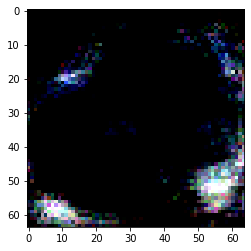

In [9]:
plt.imshow(sample[0].permute(1,2,0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


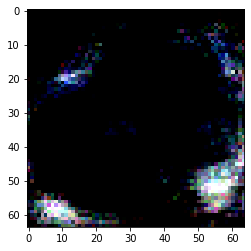

In [10]:
im_np = sample[0].permute(1, 2, 0).numpy()
plt.imshow(im_np);

# Convert the output image to base64 for deployment

### pil image size is : (64, 64)
### buff is : b''


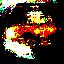

In [11]:
#pil_img = Image.fromarray((im_np * 255).astype(np.uint8))
pil_img = Image.fromarray((im_np).astype(np.uint8))
buff = BytesIO()
print(f'### pil image size is : {pil_img.size}')

print(f'### buff is : {buff.getvalue()}')
pil_img.save(buff, format="JPEG")
new_image_string = base64.b64encode(buff.getvalue()).decode("utf-8")
img_str = f"data:image/jpeg;base64,{new_image_string}"
print(img_str)

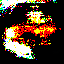

In [12]:
display(pil_img)

In [ ]:
#os.remove(modelFile)